# Hello

In [33]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils


from sklearn.preprocessing import OneHotEncoder, LabelEncoder

## Load Data

In [34]:
#load .npz-file from folder
data_folder = "data/"
loader = np.load(data_folder+"gray_image_data_xs.npz")
train_data = loader["train_features"]
train_labels = loader["train_labels"].reshape((-1,1))
val_data = loader["val_features"]
val_labels = loader["val_labels"].reshape((-1,1))

labels_length = train_labels.shape[0]
all_labels = np.append(train_labels, val_labels)
# numeric encoding
en = LabelEncoder()
all_labels = en.fit_transform(all_labels)
train_labels = all_labels[:labels_length]
val_labels = all_labels[labels_length:]

train_data = np.expand_dims(train_data, axis=1)
val_data = np.expand_dims(val_data, axis=1)

num_classes = max(train_labels)+1

In [35]:
train_data.shape

(800, 1, 100, 100)

In [36]:
train_labels.shape

(800,)

## Load data for pytorch

In [42]:
train_data = torch.FloatTensor(train_data)
train_labels = torch.LongTensor(train_labels)

train = data_utils.TensorDataset(train_data, train_labels)
train_loader = data_utils.DataLoader(train, batch_size=64, shuffle=True)

val_data = torch.FloatTensor(val_data)
val_labels = torch.LongTensor(val_labels)

val = data_utils.TensorDataset(val_data, val_labels)
val_loader = data_utils.DataLoader(val, batch_size=64, shuffle=True)

## Build Model

In [43]:
import time

In [53]:
# the Classifier stolen from Pytorch Tutorial

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        # 1 input image channel, 16 output channels(new dimension), 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(32*22*22 , 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # Flatten 2d array to pass to linear layer, -1 works for arbitrary #rows which can vary with batchsize
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    def make_plot(self):
        train_acc_dropoutreg = self.hist['train_accuracy'][-1]
        val_acc_dropoutreg = self.hist['val_accuracy'][-1]

        print("dr:",f"{train_acc_dropoutreg:.3f}",f"{val_acc_dropoutreg:.3f}")

        print(epochs, batch_size, learning_rate)
        print("maxacc,minloss at epoch: ", np.argmax(self.hist['val_accuracy']),np.argmin(self.hist['val_loss']),\
              "acc there: ", self.hist['val_accuracy'][np.argmax(self.hist['val_accuracy'])],\
             self.hist['val_accuracy'][np.argmin(self.hist['val_loss'])])

        plt.figure(figsize=(10,5))

        plt.plot(self.hist['train_loss'][0::], 
                 label="Training (dropout regularization)")
        plt.plot(self.hist['val_loss'][0::], 
                 label="Validation (dropout regularization)", linestyle="--")
        
        plt.xlabel("Epoch", fontsize=20)
        plt.ylabel("Loss", fontsize=20)
        plt.legend()
        plt.show()
    
    def run(self, data_loader, backward=True):
        running_loss = 0.0
        for i, data in enumerate(data_loader, 0):
            inputs, labels = data
            self.optimizer.zero_grad()
            outputs = self(inputs)
            loss = self.criterion(outputs, labels)
            max_index = outputs.max(dim = 1)[1]
            acc = (max_index == labels).sum()
            
            if backward:
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item()
                
        return running_loss, acc
            
    def train(self, train_data, train_labels, val_data, val_labels, epochs=20, dropout=0.0, batch_size=512):
        train_losses, train_accs = [], []
        val_losses, val_accs = [], []
        
        t = time.time()
        tr_loss, tr_acc = self.run(train_loader, backward=False)
        val_loss, val_acc = self.run(val_loader, backward=False)

        train_losses.append(tr_loss)
        train_accs.append(tr_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        for epoch in range(epochs):  # loop over the dataset multiple times
            self.running_loss = 0.0
            self.run(train_loader)
            tr_loss, tr_acc = self.run(train_loader, backward=False)
            val_loss, val_acc = self.run(val_loader, backward=False)

            train_losses.append(tr_loss)
            train_accs.append(tr_acc)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            
            self.hist={'train_loss': np.array(train_losses),
           'train_accuracy': np.array(train_accs),
           'val_loss': np.array(val_losses),
           'val_accuracy': np.array(val_accs)}
            
            if (epoch + 1) % 2 == 0:
                print(f"Epoch {epoch+1}/{epochs}")
                self.make_plot()



In [54]:
# hyperparams
epochs = 10
batch_size = 64
learning_rate = 0.001
dropout = 0.5

width, height = 100,100

zerograd 1.0967254638671875e-05
forward 0.20482087135314941
loss 0.0006291866302490234
other 0.0004899501800537109
lossitem 0.0001480579376220703
zerograd 1.4066696166992188e-05
forward 0.2792971134185791
loss 0.011385917663574219
other 0.0003268718719482422
lossitem 2.002716064453125e-05
zerograd 1.0967254638671875e-05
forward 0.23050379753112793
loss 0.011046886444091797
other 0.0008308887481689453
lossitem 2.6702880859375e-05
zerograd 9.059906005859375e-06
forward 0.18375015258789062
loss 0.008213996887207031
other 0.00043201446533203125
lossitem 5.2928924560546875e-05
zerograd 1.3113021850585938e-05
forward 0.19746780395507812
loss 0.008942842483520508
other 0.0005400180816650391
lossitem 0.00011587142944335938
zerograd 1.3113021850585938e-05
forward 0.20111799240112305
loss 0.007981061935424805
other 0.0004410743713378906
lossitem 0.00013113021850585938
zerograd 1.3828277587890625e-05
forward 0.19585084915161133
loss 0.009289979934692383
other 0.00043201446533203125
lossitem 0.000

forward 0.2118699550628662
loss 0.00035881996154785156
other 0.00024175643920898438
lossitem 1.1920928955078125e-05
zerograd 0.0008518695831298828
forward 0.22219395637512207
loss 0.0003800392150878906
other 0.00031280517578125
lossitem 8.821487426757812e-06
zerograd 0.00044989585876464844
forward 0.2581179141998291
loss 0.0017578601837158203
other 0.0005371570587158203
lossitem 9.059906005859375e-06
zerograd 0.00043702125549316406
forward 0.13366484642028809
loss 0.0005037784576416016
other 0.00036406517028808594
lossitem 8.821487426757812e-06
1 1: 7.667326927185059
zerograd 0.00048804283142089844
forward 0.34108710289001465
loss 0.0009579658508300781
other 0.0003509521484375
lossitem 3.695487976074219e-05
zerograd 0.0012958049774169922
forward 0.2817389965057373
loss 0.010024785995483398
other 0.00045800209045410156
lossitem 0.0003693103790283203
zerograd 0.00044608116149902344
forward 0.18173980712890625
loss 0.010979890823364258
other 0.00040721893310546875
lossitem 0.0001249313354

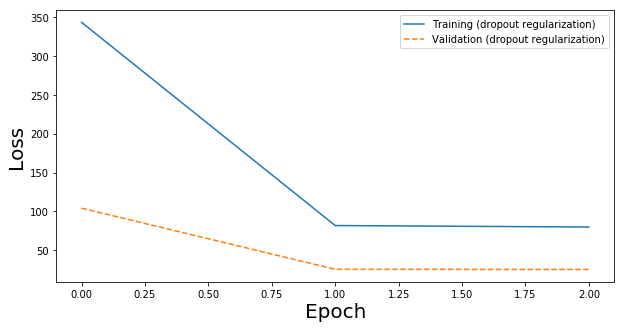

zerograd 0.0008299350738525391
forward 0.2859368324279785
loss 0.0005590915679931641
other 0.0005660057067871094
lossitem 7.867813110351562e-06
zerograd 0.0004620552062988281
forward 0.24222993850708008
loss 0.0014531612396240234
other 0.00047588348388671875
lossitem 9.298324584960938e-06
zerograd 0.0007288455963134766
forward 0.25876307487487793
loss 0.0004458427429199219
other 0.00036787986755371094
lossitem 8.344650268554688e-06
zerograd 0.0005948543548583984
forward 0.2481248378753662
loss 0.0006401538848876953
other 0.00034618377685546875
lossitem 8.821487426757812e-06
zerograd 0.00043487548828125
forward 0.22175884246826172
loss 0.0005412101745605469
other 0.0008249282836914062
lossitem 7.867813110351562e-06
zerograd 0.0004527568817138672
forward 0.21317696571350098
loss 0.0003790855407714844
other 0.0003612041473388672
lossitem 8.106231689453125e-06
zerograd 0.00045371055603027344
forward 0.21126222610473633
loss 0.0003921985626220703
other 0.0004329681396484375
lossitem 8.10623

forward 0.19244718551635742
loss 0.00041103363037109375
other 0.0003478527069091797
lossitem 3.409385681152344e-05
zerograd 0.0005199909210205078
forward 0.2365889549255371
loss 0.009168863296508789
other 0.0007059574127197266
lossitem 3.719329833984375e-05
zerograd 0.0006930828094482422
forward 0.18861794471740723
loss 0.009338140487670898
other 0.0004222393035888672
lossitem 0.00011205673217773438
zerograd 0.0012950897216796875
forward 0.032598018646240234
loss 0.012718915939331055
other 0.00037097930908203125
lossitem 3.62396240234375e-05
3 3: 0.7099511623382568
Epoch 4/10
dr: 9.000 2.000
10 64 0.001
maxacc,minloss at epoch:  4 2 acc there:  2 1


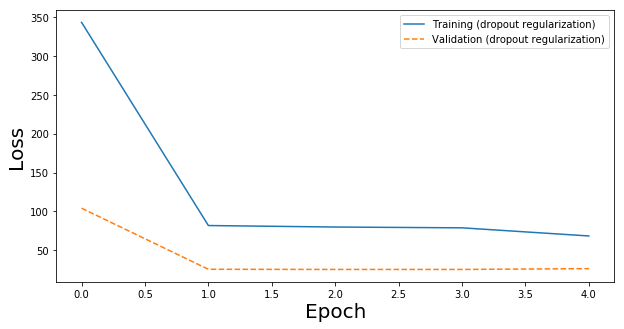

zerograd 0.0015041828155517578
forward 0.21173310279846191
loss 0.0006802082061767578
other 0.0004291534423828125
lossitem 7.867813110351562e-06
zerograd 0.0005209445953369141
forward 0.21907305717468262
loss 0.0007009506225585938
other 0.0004432201385498047
lossitem 9.059906005859375e-06
zerograd 0.00043702125549316406
forward 0.20383191108703613
loss 0.0003600120544433594
other 0.0003380775451660156
lossitem 7.867813110351562e-06
zerograd 0.0004467964172363281
forward 0.1953437328338623
loss 0.0003020763397216797
other 0.0002570152282714844
lossitem 8.821487426757812e-06
zerograd 0.00045299530029296875
forward 0.22502493858337402
loss 0.0004050731658935547
other 0.0005209445953369141
lossitem 9.059906005859375e-06
zerograd 0.0004551410675048828
forward 0.20072507858276367
loss 0.0005650520324707031
other 0.0005083084106445312
lossitem 1.0967254638671875e-05
zerograd 0.0006458759307861328
forward 0.21036696434020996
loss 0.0003788471221923828
other 0.00025010108947753906
lossitem 1.09

KeyboardInterrupt: 

In [55]:
# train model

cnn = CNN(num_classes = num_classes)
cnn.train(train_data, train_labels, val_data, val_labels, epochs=epochs, dropout=dropout, batch_size=batch_size)

In [10]:
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Finished Training


In [89]:
# evaluate model
plt.figure(figsize=(10,5))

plt.plot(cnn.hist['train_loss'][5::], 
         label="Training (dropout regularization)")
plt.plot(cnn.hist['val_loss'][5::], 
         label="Validation (dropout regularization)", linestyle="--")

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.legend()
plt.show()

AttributeError: 'CNN' object has no attribute 'hist'

<Figure size 720x360 with 0 Axes>

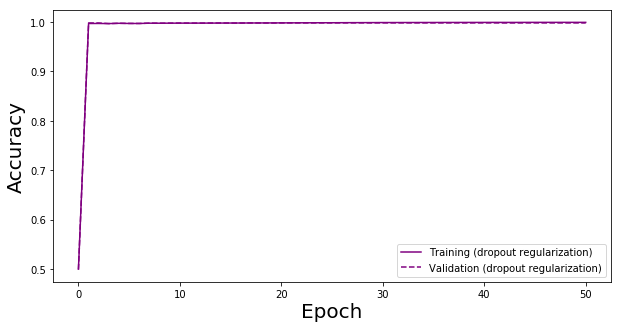

In [105]:
# Accuracy Plot
plt.figure(figsize=(10,5))

plt.plot(cnn.hist['train_accuracy'], 
         label="Training (dropout regularization)", color="purple")
plt.plot(cnn.hist['val_accuracy'], 
         label="Validation (dropout regularization)", color="purple", linestyle="--")

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.legend()
plt.show()